<a href="https://colab.research.google.com/github/marcelounb/BB/blob/master/IA2_0_v0001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Parâmetros para testes do modelo de IA no modelo "modelo_treinamento":

global_review_reduzida = False

global_vocab_size = 4000          # Tamanho máximo do vocabulário
global_embedding_dim = 128        # Tamanho do batch
global_max_length = 15           # Quantidade máxima de palavras em uma review 
num_epochs = 1

In [2]:
!pip install unidecode

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# For Tokenizing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# For N-grams
from keras.preprocessing import text
# For taking off the punctuation from text
from unidecode import unidecode

In [5]:
def reduzir_texto(frases):
  frase = ''
  for item in frases.lower().split():
    if item not in ['a', 'o', 'as', 'os', 'da', 'do', 'das', 'dos', 'e', 'no', 'na', 'em', 'i']:  # retira os artigos e conjuncao 'e'
      if item[-1] in ['.', ',', '!', ';' ]:
        frase +=str(unidecode(item[0:-1]))+' '  # retira pontuacao/acentuacao
      else:
        frase +=str(unidecode(item))+' '
  return frase[:-1]



def reduzir_review(review):
  review_reduzida = []
  for item in review:
    review_reduzida.append(reduzir_texto(item))
  return review_reduzida



def average_review_size(reviews):  
  average=[]
  [average.append(len(review.split(' '))) for review in reviews]
  print("Média do tamanho das Reviews: {:.2f} palavras por review".format(sum(average)/len(reviews)))
  averagenp = np.array(average)
  plt.hist(averagenp, bins=50) 
  plt.ylabel('Frequencia')
  plt.plot()



def acrescentando_dimensionalidade(listagem1):
  # Pega uma lista do tipo:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] e transforma em [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
  return [[int(item)] for item in listagem1] 



def tokenizing_review(reviews, review_reduzida):
  # Tokenizing values
  vocab_size = global_vocab_size
  embedding_dim = global_embedding_dim
  max_length = global_max_length
  oov_tok = "<OOV>"

  if global_review_reduzida:  # Se o parâmetro review for True, reduz a review
    reviews = reduzir_review(reviews)

  tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
  tokenizer.fit_on_texts(reviews)
  sequences = tokenizer.texts_to_sequences(reviews)
  word_index = tokenizer.word_index

  # Padding the sequences
  trunc_type='post'
  padding_type='post'
  sequences = pad_sequences(sequences,maxlen=global_max_length, padding=padding_type, truncating=trunc_type)  # Acrescentando zeros ao review
  return tokenizer, sequences, word_index



def montar_dataset(column1, column2, column3):  # Transforma 3 colunas do dataset em um unico input (score+review+colunaX) 
  column1 = acrescentando_dimensionalidade(column1)
  column3 = acrescentando_dimensionalidade(column3)
  listanova_X, listanova_y = [],[]
  for i in range(len(column1)):
    listanova_X.append(column1[i]+list(column2[i]))
    listanova_y.append(column3[i])
  lista_pandas_X = pd.DataFrame(listanova_X)
  lista_pandas_y = pd.DataFrame(listanova_y)
  return lista_pandas_X, lista_pandas_y



def split_the_dataset(dataset):
  len(dataset)



def print_baseline_error(model, model_id, X_test, y_test):
  scores = model.evaluate(X_test, y_test, verbose=0)
  print("Baseline Error " + model_id + " : %.2f%%" % (100-scores[1]*100))

Definindo os modelos de IA

In [6]:
# define the model
def model1(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 100, input_length=max_length))
  model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # compile network
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # summarize defined model
  # model.summary()
  return model

Média do tamanho das Reviews: 22.57 palavras por review
Tamanho do dicionário: 205
Baseline Error Alívio de Numerário : 0.00%
Baseline Error Aplicativo : 33.33%
Baseline Error App ourocard : 33.33%


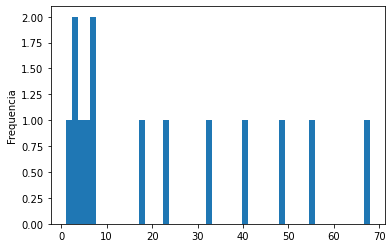

In [7]:
# Main

path = "/content/fulldataset_IA20.xlsx"
dataset = pd.read_excel(path, sheet_name=0, header=0, dtype={'score': np.int32})
dataset = dataset.fillna(0)

# Show the average size of the reviews
average_review_size(dataset['review'])

# Tokenizing and Padding the reviews
tokenizer, sequences, word_index = tokenizing_review(dataset['review'], review_reduzida=global_review_reduzida)
print('Tamanho do dicionário: ' + str(len(word_index)))


# lista das colunas de Produtos/Servicos a serem aprendidos e preditos  -  colunas de 17 a 20
lista_colunas = list(dataset.keys())[17:20]

# monta o dataset, treina e salva
for cada_coluna in lista_colunas:
  # Splitting the dataset into X and y
  new_dataset_X, new_dataset_y = montar_dataset(dataset['score'], sequences, dataset[cada_coluna])
  # Splitting into train and test
  X_train, X_test, y_train, y_test = train_test_split(new_dataset_X, new_dataset_y, test_size=0.20, random_state=42)
  
  # Choosing the model
  model = model1(max_length=global_max_length+1, vocab_size=global_vocab_size)  
  hist = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test), verbose=0)

  # Showing the Baseline Error
  print_baseline_error(model, cada_coluna, X_test, y_test)

  # Saving the model
  model.save("/content/models/" + cada_coluna + '.h5')

In [8]:
!zip -r "/content/models.zip" "/content/models/"

updating: content/models/ (stored 0%)
updating: content/models/Aplicativo.h5 (deflated 64%)
updating: content/models/App ourocard.h5 (deflated 64%)
updating: content/models/Alívio de Numerário.h5 (deflated 64%)
